# Preparation

In [4]:
import os
import sys

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning
from nlp import tokenize_doc

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=True, categories_reduced=False
)
# jobs.head()

In [5]:
jobs = jobs[
    (jobs["Description"] != "Nicht stepstone")
    & (jobs["Description"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Description"] != "")
    & (jobs["Profile"] != "")
	& (jobs["Gehalt_min_yearly"]).notna()
]

texts = jobs["Titel"] + " " + jobs["Description"] + " " + jobs["Profile"]

# Preprocessing

In [6]:
import pickle

if os.path.isfile("../data/lemmatized.pkl"):
    with open("../data/lemmatized.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas
        
    with open("../data/lemmatized.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 3285 documents
500/3285
1000/3285
1500/3285
2000/3285
2500/3285
3000/3285


In [7]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('data', 8419),
 ('team', 3159),
 ('bereich', 3157),
 ('erfahrung', 3118),
 ('business', 2871),
 ('kenntnis', 2768),
 ('analyst', 2119),
 ('management', 2118),
 ('analyse', 2101),
 ('abgeschlossen', 2026)]

In [8]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import numpy as np


def vec_lsa(documents):
    # Feature Extraction using TfidfVectorizer

    vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        min_df=5,
        max_df=0.5
    )

    t0 = time()
    X_tfidf = vectorizer.fit_transform(documents)

    print(f"vectorization done in {time() - t0:.3f} s")
    print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

    print(f"Sparsity: {X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

    # Performing dimensionality reduction using LSA
    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
    t0 = time()
    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()

    print(f"LSA done in {time() - t0:.3f} s")
    print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

    return vectorizer, X_tfidf, lsa, X_lsa

In [9]:
vectorizer_all, X_tfidf_all, lsa_all, X_lsa_all = vec_lsa(lemmas)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


vectorization done in 0.133 s
n_samples: 3285, n_features: 6170
Sparsity: 0.013
LSA done in 0.577 s
Explained variance of the SVD step: 25.6%


# Clustering with kmeans

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def cluster_means(n, X_lsa):
    t0 = time()

    inertias = {}
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, max_iter=100, n_init=1, random_state=1)

        kmeans.fit(X_lsa)
        inertias[k] = kmeans.inertia_

    print(f"Clustering done in {time() - t0:.3f} s")

    plt.figure()
    plt.plot(inertias.keys(), inertias.values())
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()


def terms_per_cluster(lsa, vectorizer, kmeans, n):
    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(n):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :20]:
            print(f"{terms[ind]} ", end="")
        print()

Clustering done in 1.986 s


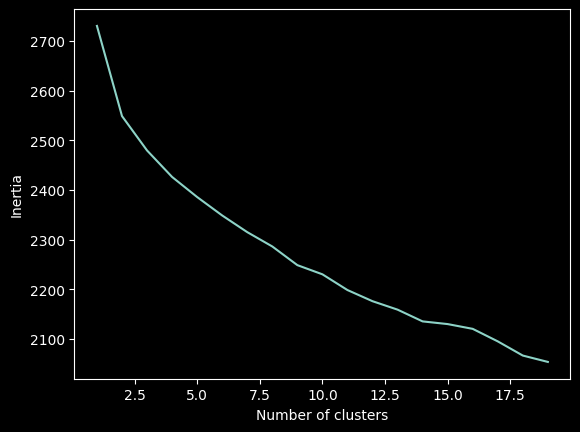

In [11]:
cluster_means(20, X_lsa_all)

# Top terms per Cluster

In [12]:
cluster_count=2
kmeans_all = KMeans(
    n_clusters=cluster_count,
    max_iter=100,
    n_init=1,
	random_state=2
)


kmeans_all.fit(X_lsa_all)

terms_per_cluster(lsa_all, vectorizer_all, kmeans_all, cluster_count)

Cluster 0: analyse business team datum prozeß analyst vergleichbar entwicklung projekt technisch arbeiten analytisch unser kunde sap fähigkeit hoch deutsch berufserfahrung lösung 
Cluster 1: experience skills business project knowledg team work management analysis solution development processes supporen working strong english well degree technical quality 


Wir stellen fest, dass wir Jobs in Deutsch und Englisch haben. Wir wollen unsere Analyse aber auf deutsche Jobs beschränken. Also wollen wir nur noch mit Dokumenten aus Cluster 0 arbeiten

In [19]:
labels = kmeans_all.labels_

indeces_cluster_german = np.where(labels == 0)[0]

german_docs = [lemmas[i] for i in indeces_cluster_german]
print(f"{len(german_docs)} german documents")

2883 german documents


In [20]:
vectorizer_ger, X_tfidf_ger, lsa_ger, X_lsa_ger = vec_lsa(german_docs)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


vectorization done in 0.154 s
n_samples: 2883, n_features: 4885
Sparsity: 0.016
LSA done in 1.892 s
Explained variance of the SVD step: 26.4%


Clustering done in 8.449 s


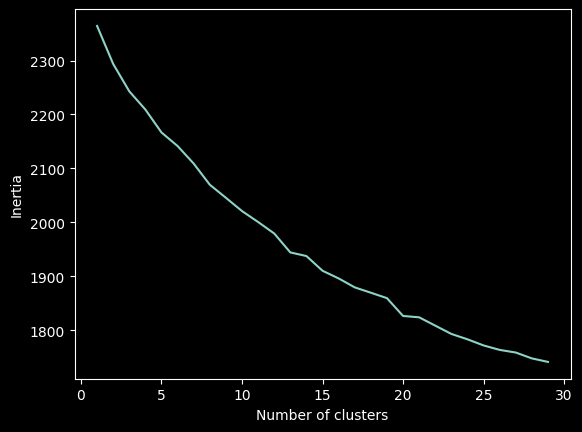

In [22]:
cluster_means(30, X_lsa_ger)

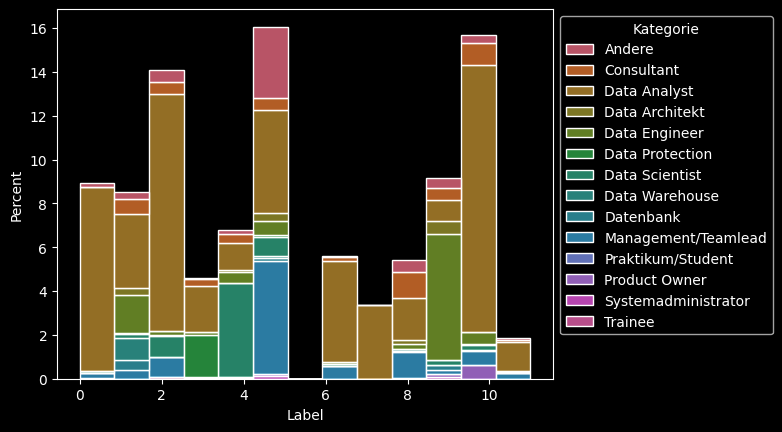

In [23]:
import seaborn as sns

kmeans_ger = KMeans(
    n_clusters=12,
    max_iter=100,
    n_init=1,
	random_state=2
)

kmeans_ger.fit(X_lsa_ger)

labels = kmeans_ger.labels_

df_eval = pd.DataFrame(
    {"Label": labels, "Kategorie": jobs.iloc[indeces_cluster_german, 18]}
)

# display(df_eval.groupby("Kategorie").value_counts(subset=["Label"], normalize=True))
by_label = df_eval.groupby("Label").value_counts(subset=["Kategorie"], normalize=True)

ax = sns.histplot(
    data=df_eval, x="Label", hue="Kategorie", multiple="stack", stat="percent"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# terms_per_cluster(lsa, vectorizer, kmeans, 2)

In [24]:
# jobs einmal nach cluster und einmal nach kategorie aufteilen
# für jede gruppe training split mit GridSearchCV
# gehalt vorhersagen